In [15]:
!wget https://raw.githubusercontent.com/UtkarshRaj130/Advanced_Soybean_Agricultural_Dataset_Analysis/refs/heads/main/Dataset/3_duplicates_removed.csv -O 3_duplicates_removed.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [22]:
# --- LIBRARIES ---
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")


# 1. Load Dataset + Preprocessing

In [32]:
print(df.columns.tolist())


['Parameters', 'Random ', 'Plant Height (PH)', 'Number of Pods (NP)', 'Biological Weight (BW)', 'Sugars (Su)', 'Relative Water Content in Leaves (RWCL)', 'ChlorophyllA663', 'Chlorophyllb649', 'Protein Percentage (PPE)', 'Weight of 300 Seeds (W3S)', 'Leaf Area Index (LAI)', 'Seed Yield per Unit Area (SYUA)', 'Number of Seeds per Pod (NSP)', 'Protein Content (PCO)', 'C_2', 'S_2', 'S_3', 'G_2', 'G_3', 'G_4', 'G_5', 'G_6']


In [35]:
# Load data
df = pd.read_csv("3_duplicates_removed.csv").drop_duplicates()

# Define target and all features
selected_features = ["Sugars (Su)", "Weight of 300 Seeds (W3S)",
                     "Seed Yield per Unit Area (SYUA)", "Number of Seeds per Pod (NSP)",
                     "Protein Percentage (PPE)", "Protein Content (PCO)"]

all_features = df.columns.difference(["Parameters", "Random "])  # drop ID/meta if needed

# Clean
df = df.dropna(subset=selected_features)
df = df.reset_index(drop=True)

# Feature Sets
X_all = df[all_features].copy()
X_selected = df[selected_features].copy()

# Scale both
scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

scaler_sel = StandardScaler()
X_sel_scaled = scaler_sel.fit_transform(X_selected)


 # 2. SHAP Scoring Function

In [38]:
def compute_shap_cluster_score(X_input, cluster_labels, model_output='probability'):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_input, cluster_labels, stratify=cluster_labels, random_state=42)
    model.fit(X_train, y_train)

    explainer = shap.Explainer(model, X_input, model_output=model_output)
    shap_values = explainer(X_input, check_additivity=False)

    n_clusters = len(np.unique(cluster_labels))
    cluster_avg_shap = {}

    for cluster_id in range(n_clusters):
        indices = np.where(cluster_labels == cluster_id)[0]
        if len(indices) == 0:
            continue
        shap_cluster = shap_values.values[indices, :, cluster_id]
        cluster_shap_mean = np.abs(shap_cluster).mean(axis=0)
        cluster_avg_shap[cluster_id] = cluster_shap_mean.mean()

    if len(cluster_avg_shap) == 0:
        return {}, 0.0, 0.0

    overall_avg = np.mean(list(cluster_avg_shap.values()))
    overall_std = np.std(list(cluster_avg_shap.values()))

    return cluster_avg_shap, overall_avg, overall_std


# 3.  Fit Cluster Models on Both Feature Sets

In [43]:
from collections import OrderedDict

k_values = [2, 5, 6, 7]
cluster_models = OrderedDict()

# -- KMeans
for k in k_values:
    cluster_models[f"KMeans_k={k}_all"] = KMeans(n_clusters=k, random_state=42).fit_predict(X_all_scaled)
    cluster_models[f"KMeans_k={k}_sel"] = KMeans(n_clusters=k, random_state=42).fit_predict(X_sel_scaled)

# -- KMedoids
for k in k_values:
    cluster_models[f"KMedoids_k={k}_all"] = KMedoids(n_clusters=k, random_state=42).fit_predict(X_all_scaled)
    cluster_models[f"KMedoids_k={k}_sel"] = KMedoids(n_clusters=k, random_state=42).fit_predict(X_sel_scaled)

# -- GMM (only 6, 7)
for k in [6, 7]:
    cluster_models[f"GMM_k={k}_all"] = GaussianMixture(n_components=k, random_state=42).fit(X_all_scaled).predict(X_all_scaled)
    cluster_models[f"GMM_k={k}_sel"] = GaussianMixture(n_components=k, random_state=42).fit(X_sel_scaled).predict(X_sel_scaled)

#  4.  Evaluate All Clustering Models

In [44]:
results = {
    "Model": [],
    "Feature_Set": [],
    "Average SHAP": [],
    "SHAP Std Dev": [],
    "Stability Score (Avg/Std)": []
}

# Run SHAP evaluations
for name, labels in cluster_models.items():
    if "_all" in name:
        X_used = X_all
        feat_set = "All Features"
    else:
        X_used = X_selected
        feat_set = "Selected Features"

    print(f"🔍 {name}")
    _, avg, std = compute_shap_cluster_score(X_used, labels)
    score = avg / std if std > 0 else 0
    
    results["Model"].append(name.replace("_all", "").replace("_sel", ""))
    results["Feature_Set"].append(feat_set)
    results["Average SHAP"].append(avg)
    results["SHAP Std Dev"].append(std)
    results["Stability Score (Avg/Std)"].append(score)

🔍 KMeans_k=2_all
🔍 KMeans_k=2_sel
🔍 KMeans_k=5_all
🔍 KMeans_k=5_sel
🔍 KMeans_k=6_all
🔍 KMeans_k=6_sel
🔍 KMeans_k=7_all
🔍 KMeans_k=7_sel
🔍 KMedoids_k=2_all
🔍 KMedoids_k=2_sel
🔍 KMedoids_k=5_all
🔍 KMedoids_k=5_sel
🔍 KMedoids_k=6_all
🔍 KMedoids_k=6_sel
🔍 KMedoids_k=7_all
🔍 KMedoids_k=7_sel
🔍 GMM_k=6_all
🔍 GMM_k=6_sel
🔍 GMM_k=7_all
🔍 GMM_k=7_sel


# 5. Visualize the Results - Side-by-Side Comparison Plot

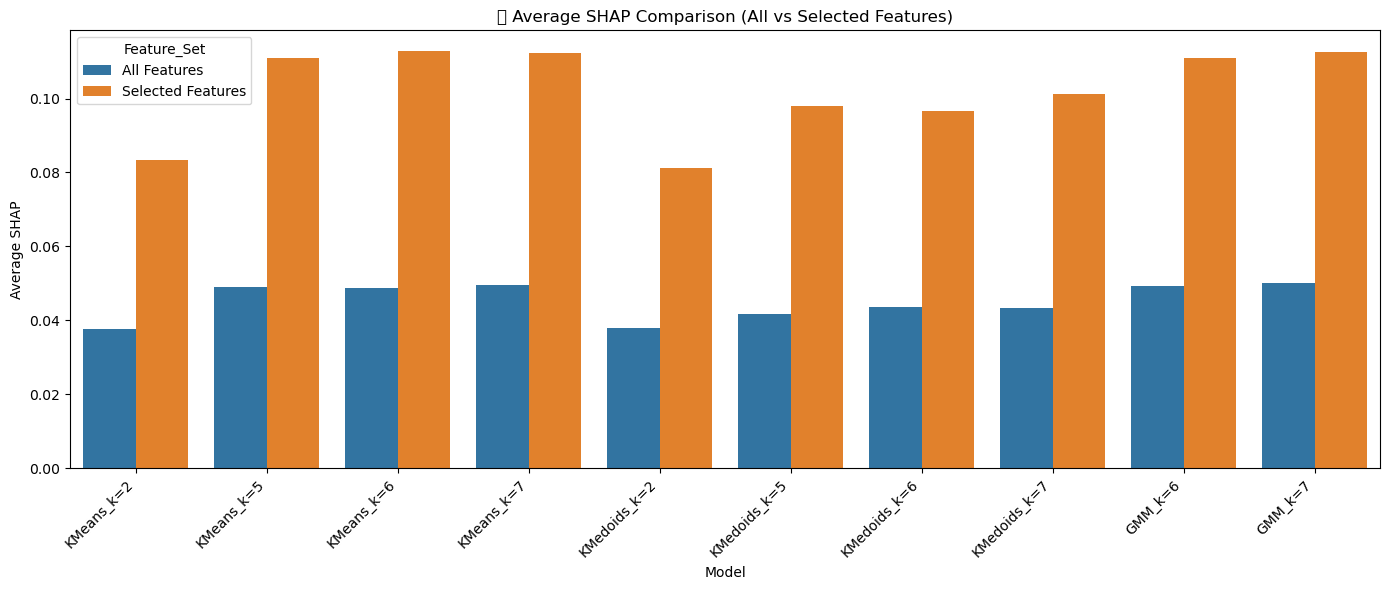

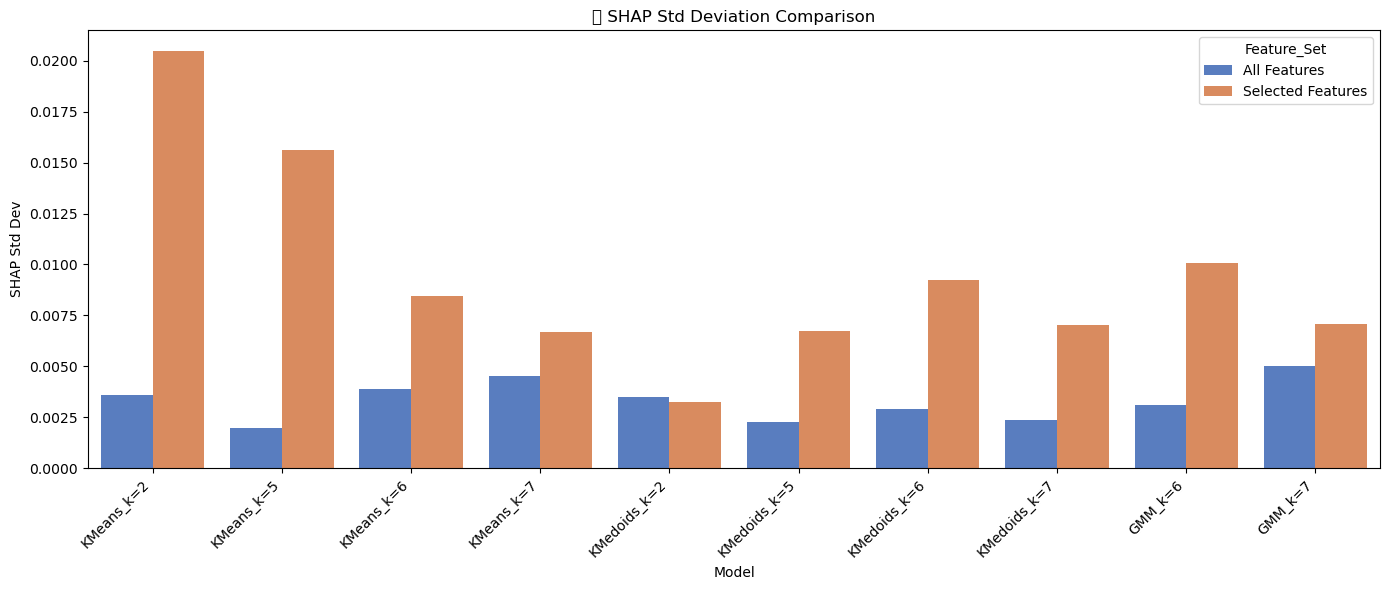

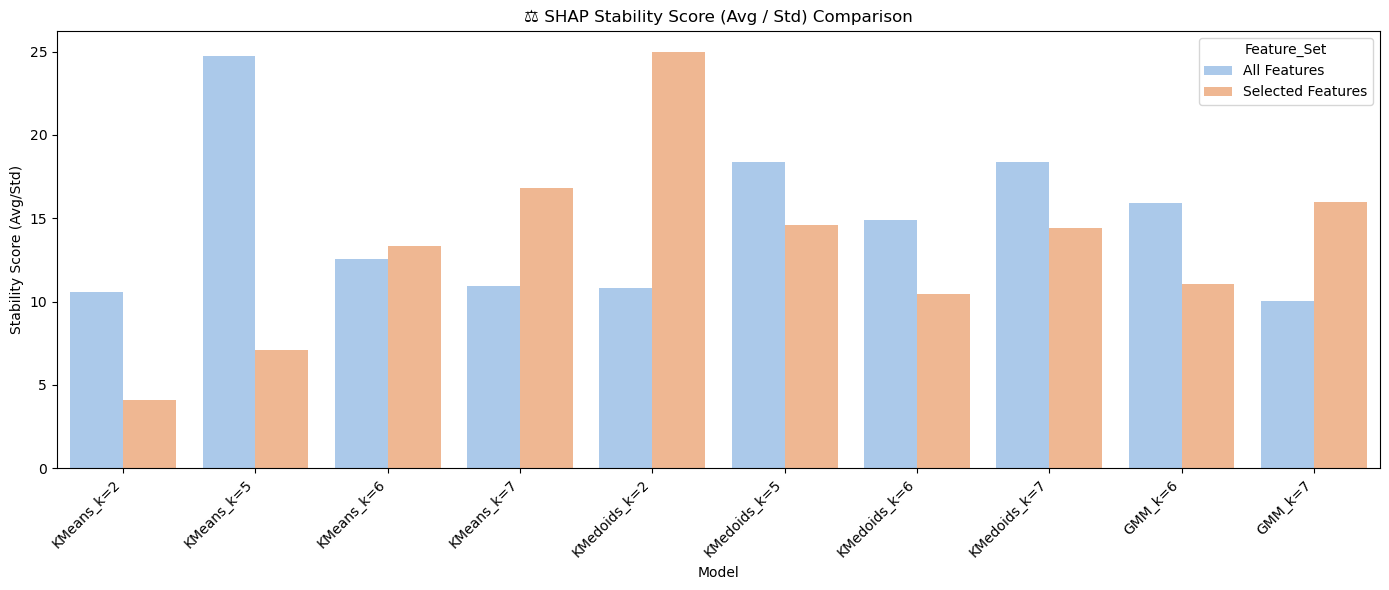

In [45]:
# Convert to DataFrame
df_results = pd.DataFrame(results)

# Grouped barplot for SHAP Avg
plt.figure(figsize=(14, 6))
sns.barplot(data=df_results, x="Model", y="Average SHAP", hue="Feature_Set")
plt.title("📊 Average SHAP Comparison (All vs Selected Features)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Std Dev
plt.figure(figsize=(14, 6))
sns.barplot(data=df_results, x="Model", y="SHAP Std Dev", hue="Feature_Set", palette="muted")
plt.title("📉 SHAP Std Deviation Comparison")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Stability Score
plt.figure(figsize=(14, 6))
sns.barplot(data=df_results, x="Model", y="Stability Score (Avg/Std)", hue="Feature_Set", palette="pastel")
plt.title("⚖️ SHAP Stability Score (Avg / Std) Comparison")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

 (Optional) Export Results

In [46]:
df_results.to_csv("shap_clustering_comparison.csv", index=False)